In [1]:
#!pip3 install pydotplus --user

%load_ext autoreload
%autoreload 2

In [2]:
import data_process, data_functions
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import matplotlib.pyplot as plt

In [3]:
#load pmpm data only
#notebooks/causal_data_creation/biometric_matching_X
canary, biometrics, pmpm = data_process.load_data()

In [4]:
del canary, biometrics

### PMPM Analysis


In [5]:
pmpm.head()

PERS_ID  AGE_AT_MIDMONTH  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  \
0  2570122               95      40392        0             0   
1  2570122               94      19837        0             0   
2  2570268               93       4922        0             1   
3  2570268               94        232        0             1   
4  2570268               93       2776        0             1   

   CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  \
0                  1       0          1                    0             0   
1                  0       0          1                    0             1   
2                  1       0          1                    0             1   
3                  1       0          1                    0             1   
4                  1       0          1                    0             1   

   ...  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  \
0  ...                 0                       1               0   
1  ...                 0                       0               0   
2  ...                 0                       0               0   
3  ...                 0                       0               0   
4  ...                 0                       0               0   

   CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  \
0                0          0           0                   0   
1                0          0           0                   0   
2                0          0           0                   0   
3                0          0           0                   0   
4                0          0           0                   0   

   CC_VISUAL_IMPAIR  MBR_GNDR     MYR  
0                 0         M  202002  
1                 0         M  201810  
2                 0         F  201704  
3                 0         F  201807  
4                 0         F  201801  

[5 rows x 74 columns]

### Create Training Feature

In [6]:
train_X = (pmpm.query("MYR>=201701 & MYR<=201712 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in train_X.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=train_X,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=train_X, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
train_X = B.merge(A, how='left', on='PERS_ID').reset_index()

In [7]:
train_Y = (pmpm.query("MYR>=201901 & MYR<=201901 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in train_Y.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=train_Y,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=train_Y, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
train_Y = B.merge(A, how='left', on='PERS_ID').reset_index()

In [8]:
commonPMPM = np.intersect1d(train_X.PERS_ID, train_Y.PERS_ID)

In [9]:
train_X = train_X[train_X.PERS_ID.isin(commonPMPM)]
train_Y = train_Y[train_Y.PERS_ID.isin(commonPMPM)]

In [10]:
train_X = train_X.set_index('PERS_ID')
train_Y = train_Y.set_index('PERS_ID')

In [11]:
train_X.columns

Index(['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_INT_DISAB', 'CC_ISCHEMIC',
       '

### Create Validation Data

In [12]:
diabetes_onset_ids = np.intersect1d(train_X.loc[train_X.CC_DIABETES==0].reset_index().PERS_ID, train_Y.loc[train_Y.CC_DIABETES==1].reset_index().PERS_ID)
np.random.seed(0)
diabetes_onset_ids = np.random.choice(diabetes_onset_ids, 1000, replace=False)

In [13]:
valid_X = train_X.loc[train_X.index.isin(diabetes_onset_ids)]
valid_Y = train_Y.loc[train_Y.index.isin(diabetes_onset_ids)]

In [14]:
train_X = train_X.loc[~train_X.index.isin(diabetes_onset_ids)]
train_Y = train_Y.loc[~train_Y.index.isin(diabetes_onset_ids)]

In [15]:
train_X.shape

(124071, 72)

### Creating Test Feature

In [16]:
test_X = (pmpm.query("MYR>=201801 & MYR<=201812 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in test_X.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=test_X,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=test_X, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
test_X = B.merge(A, how='left', on='PERS_ID').reset_index()

In [17]:
test_Y = (pmpm.query("MYR>=202001 & MYR<=202001 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in test_Y.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=test_Y,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=test_Y, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
test_Y = B.merge(A, how='left', on='PERS_ID').reset_index()

In [18]:
commonPMPMtest = np.intersect1d(test_X.PERS_ID, test_Y.PERS_ID)
test_X = test_X[test_X.PERS_ID.isin(commonPMPMtest)]
test_Y = test_Y[test_Y.PERS_ID.isin(commonPMPMtest)]
test_X = test_X.set_index('PERS_ID')
test_Y = test_Y.set_index('PERS_ID')

### Train Model

In [19]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K

In [58]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
            
my_callback = MyThresholdCallback(threshold=0.20)

In [21]:
# #model architecture
# model = models.Sequential()
# model.add(layers.Dense(64, input_dim=72, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(8, activation='relu', name='latent'))
# model.add(layers.Dense(1, activation='sigmoid'))
    
# #compile and fit 
# my_callback = MyThresholdCallback(threshold=0.15)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(train_X.values, train_Y.CC_DIABETES.values, epochs=50, validation_data=(valid_X.values, valid_Y.CC_DIABETES.values), batch_size=128, callbacks=[my_callback])

In [22]:
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# sess = tf.Session()
# sess.run(init_g)
# sess.run(init_l)

In [23]:
# #define callbacks
# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, mode='max', baseline=0.20)
# ]

In [67]:
def make_model(output_bias=None):
    
    #output bias initializer
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    #sequential model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(64, input_dim=72, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(8, activation='relu', name='latent'))
    
    model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    
    #compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    
    return model
    

In [70]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                4672      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
latent (Dense)               (None, 8)                 136       
__________

In [71]:
baseline_history = model.fit(train_X.values, train_Y.CC_DIABETES.values, epochs=100, validation_data=(valid_X.values, valid_Y.CC_DIABETES.values), batch_size=128, callbacks=[my_callback])

Train on 124071 samples, validate on 1000 samples
Epoch 1/100
124071/124071 [==============================] - 3s 21us/step - loss: 1.7275 - acc: 0.8088 - val_loss: 1.6811 - val_acc: 0.0000e+00
Epoch 2/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.5300 - acc: 0.8224 - val_loss: 1.7520 - val_acc: 0.0240
Epoch 3/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.4608 - acc: 0.8249 - val_loss: 1.8216 - val_acc: 0.0140
Epoch 4/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.4472 - acc: 0.8260 - val_loss: 2.1544 - val_acc: 0.0000e+00
Epoch 5/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.4236 - acc: 0.8260 - val_loss: 2.1143 - val_acc: 0.0100
Epoch 6/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.3433 - acc: 0.8474 - val_loss: 3.2977 - val_acc: 0.0020
Epoch 7/100
124071/124071 [==============================] - 2s 16us/step - loss: 0.2079 - acc: 0.9315

In [73]:
#freeze all the layers
for layer in model.layers:
    layer.trainable=False

## Performance

In [74]:
_, train_accuracy = model.evaluate(train_X.values, train_Y.CC_DIABETES.values)
print('Train Accuracy: %.2f' % (train_accuracy*100))

124071/124071 [==============================] - 2s 14us/step
Train Accuracy: 84.09


In [75]:
_, test_accuracy = model.evaluate(test_X.values, test_Y.CC_DIABETES.values)
print('Test Accuracy: %.2f' % (test_accuracy*100))

137492/137492 [==============================] - 2s 14us/step
Test Accuracy: 83.52


In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics= ['loss', 'acc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

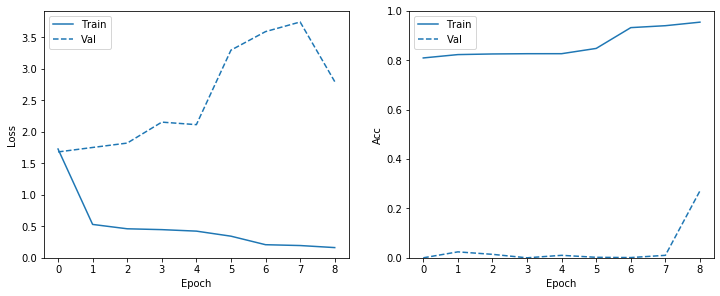

In [77]:
plot_metrics(baseline_history)

In [78]:
train_predictions_baseline = model.predict(train_X.values)
test_predictions_baseline = model.predict(test_X.values)

In [79]:
train_labels = train_Y.CC_DIABETES.values
test_labels = test_Y.CC_DIABETES.values

Balanced Accuracy: average of recall obtained on each class.

In [80]:
from sklearn.metrics import balanced_accuracy_score
print(f"Train Balanced Accuracy: {balanced_accuracy_score(train_labels, np.round_(train_predictions_baseline)):0.2f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(test_labels, np.round_(test_predictions_baseline)):0.2f}")

Train Balanced Accuracy: 0.88
Test Balanced Accuracy: 0.86


In [81]:
from sklearn.metrics import roc_curve 
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

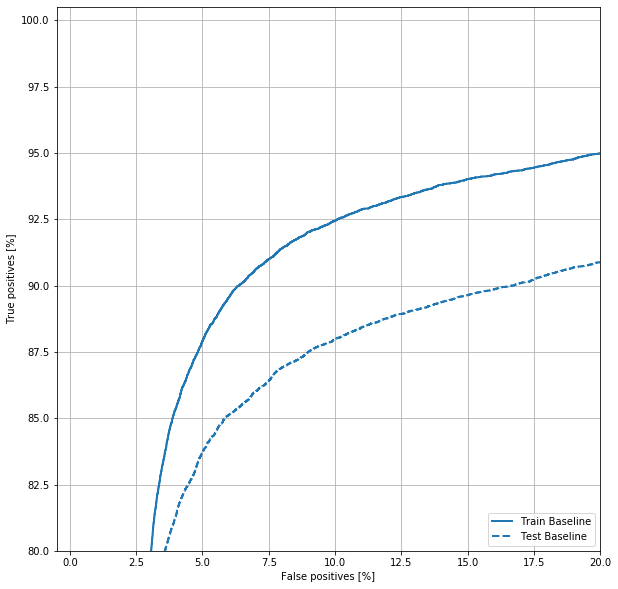

In [82]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Analysis for latent projection

In [83]:
diabetes_onset_ids = np.intersect1d(train_X.loc[train_X.CC_DIABETES==0].reset_index().PERS_ID, train_Y.loc[train_Y.CC_DIABETES==1].reset_index().PERS_ID)
t_X = train_X.loc[train_X.index.isin(diabetes_onset_ids)]
t_Y = train_Y.loc[train_Y.index.isin(diabetes_onset_ids)]
_, accuracy = model.evaluate(t_X.values, t_Y.CC_DIABETES.values)
print('Validation Accuracy: %.2f' % (accuracy*100))

941/941 [==============================] - 0s 16us/step
Validation Accuracy: 26.46


### Get the latent projection

In [84]:
model._layers.pop()
model2 = tf.keras.Model(model.input, model.layers[-1].output)

In [85]:
#(n_samples, 8)
model2.predict(test_X).shape

In [86]:
## save the model
model2.save('./TF_Model')

In [123]:
model2.save_weights('./TF_Model_valacc_27_POP_Weights')

### Load Matched Data

In [105]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np, pandas as pd

In [106]:
model = models.load_model("./TF_Model_valacc_27_POP", compile=False)

In [107]:
matching_data = "../../matching_data/data_bmi.p"
data = pd.read_pickle(matching_data)

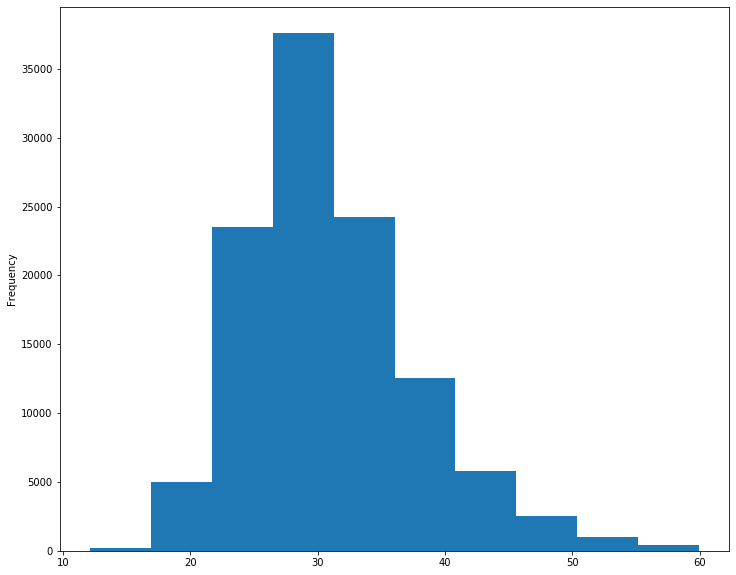

In [108]:
data.RESULT_VALUE.plot(kind='hist')

In [109]:
#data = data.dropna(subset=['RESULT_VALUE'])

In [110]:
data = data.reset_index(drop=True)

In [111]:
data.head(5)

AGE_AT_MIDMONTH  ALLOW_AMT BIOMETRIC_CATEGORY  CC_ADHD  CC_ALZHEIMER  \
0               81          0                NaN        0             0   
1               82        101                BMI        0             0   
2               78      13007                BMI        0             0   
3               77          0                BMI        0             0   
4               76        898                BMI        0             0   

   CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  \
0                  0       0          0                    1             0   
1                  0       0          0                    1             0   
2                  0       0          0                    0             1   
3                  0       0          0                    0             0   
4                  0       0          0                    0             1   

   ...  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  MBR_GNDR  OUTCOME  OUTCOME2  \
0  ...                   0                 0         0        0       NaN   
1  ...                   0                 0         0        0       NaN   
2  ...                   0                 0         1        0  0.099021   
3  ...                   0                 0         0        0       NaN   
4  ...                   0                 0         1        1 -0.340599   

   OUTCOME3  PERS_ID  RESULT_VALUE  RESULT_VALUE2  TREATED  
0       1.0  2602482           NaN              1        1  
1       1.0  2603072     29.256837              0        1  
2       1.0  2621187     23.289228              1        1  
3       1.0  2623521     33.928182              0        1  
4       1.0  2633716     40.305640              0        1  

[5 rows x 80 columns]

In [112]:
A = data.loc[:,["AGE_AT_MIDMONTH", "MBR_GNDR", "ALLOW_AMT"]]
B = data.loc[:,"CC_ADHD":"CC_VISUAL_IMPAIR"]
X = A.merge(B, how='left', left_index=True, right_index=True)
T = data.TREATED
Y = data.RESULT_VALUE2

### Project X into latent space

In [113]:
latent = model.predict(X)

In [114]:
latent = pd.DataFrame(latent, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"])

In [115]:
new_data = pd.concat([latent,Y,T], axis=1)

### Run DO WHY

In [116]:
from dowhy import CausalModel

In [117]:
common_causes = latent.columns.tolist()

In [118]:
new_data = new_data.astype({"TREATED":'bool'}, copy=False)

In [119]:
new_data

x1          x2   x3        x4         x5        x6   x7         x8  \
0       0.0    0.000000  0.0  6.547295   0.000000  4.301954  0.0   3.292125   
1       0.0    0.000000  0.0  6.013276   0.002326  3.531082  0.0   3.519185   
2       0.0   18.320408  0.0  0.000000   8.193006  0.000000  0.0   6.011943   
3       0.0    0.000000  0.0  6.142557   0.000000  3.724085  0.0   3.282231   
4       0.0    0.000000  0.0  6.517014   2.041188  4.714298  0.0   2.036397   
...     ...         ...  ...       ...        ...       ...  ...        ...   
113313  0.0    0.000000  0.0  5.630129   1.242882  3.492501  0.0   1.837288   
113314  0.0    0.000000  0.0  5.725319   1.595535  3.632679  0.0   1.679852   
113315  0.0    0.000000  0.0  4.896411   2.410692  2.780802  0.0   0.792051   
113316  0.0  168.645386  0.0  0.000000  68.134384  0.000000  0.0  58.706036   
113317  0.0    0.000000  0.0  4.993860   1.786676  2.823154  0.0   1.062617   

        RESULT_VALUE2  TREATED  
0                   1     True  
1                   0     True  
2                   1     True  
3                   0     True  
4                   0     True  
...               ...      ...  
113313              0    False  
113314              0    False  
113315              0    False  
113316              1    False  
113317              0    False  

[113318 rows x 10 columns]

### 1. Propensity Score Matching

In [120]:
%%time
#----------------------------
#step 1: Create Causal Model
#----------------------------
PSM_model=CausalModel(
        data = new_data,
        treatment='TREATED',
        outcome='RESULT_VALUE2',
        common_causes=common_causes
        )
print("Step 1: Causal Model Created")
#------------------------------
#step 2: Identify the Estimand
#------------------------------
PSM_identified_estimand = PSM_model.identify_effect(proceed_when_unidentifiable=True)
print("Step 2: Estimand Identified")

#------------------------------
#step 3: Estimating the Effect
#------------------------------
PSM_estimate = PSM_model.estimate_effect(PSM_identified_estimand,
        method_name="backdoor.propensity_score_matching",
        target_units = "ate"
)
print("Step 3: Estimated the treatment effect")
print("Causal Estimate is " + str(PSM_estimate.value))

#------------------------------
#step 4: Refutation
#------------------------------
print("Step 4: Refutation")
#refute using common cause
#solution: Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)
refute_random_common_cause = PSM_model.refute_estimate(
                                        PSM_identified_estimand,
                                        PSM_estimate,
                                        method_name="random_common_cause"
                                    )
print("a. After random common cause refutation --")
print(refute_random_common_cause)

#refute using placebo treatment
#What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)
refute_placebo_treatment = PSM_model.refute_estimate(
                                    PSM_identified_estimand,
                                    PSM_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print("b. After placebo treatment refutation --")
print(refute_placebo_treatment)

#refute using random subset
#Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)
refute_random_subset = PSM_model.refute_estimate(
                                    PSM_identified_estimand,
                                    PSM_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8
                            )
print("c. After random subset refutation --")
print(refute_random_subset)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['TREATED'] on outcome ['RESULT_VALUE2']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x8', 'x3', 'x4', 'x2', 'x6', 'x1', 'x5', 'U', 'x7']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl

Step 1: Causal Model Created
Step 2: Estimand Identified


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7+w_random


Step 3: Estimated the treatment effect
Causal Estimate is 0.1849838507562788
Step 4: Refutation


/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~placebo+x8+x3+x4+x2+x6+x1+x5+x7


a. After random common cause refutation --
Refute: Add a Random Common Cause
Estimated effect:(0.1849838507562788,)
New effect:(0.15729186889990998,)



/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7


b. After placebo treatment refutation --
Refute: Use a Placebo Treatment
Estimated effect:(0.1849838507562788,)
New effect:(0.021029315730951834,)



/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c. After random subset refutation --
Refute: Use a subset of data
Estimated effect:(0.1849838507562788,)
New effect:(0.1785028790786948,)

CPU times: user 4min 43s, sys: 27 s, total: 5min 10s
Wall time: 4min 13s


### 2. Propensity Score Stratification

In [121]:
%%time
#----------------------------
#step 1: Create Causal Model
#----------------------------
PSS_model=CausalModel(
        data = new_data,
        treatment='TREATED',
        outcome='RESULT_VALUE2',
        common_causes=common_causes
        )
print("Step 1: Causal Model Created")

#------------------------------
#step 2: Identify the Estimand
#------------------------------
PSS_identified_estimand = PSS_model.identify_effect(proceed_when_unidentifiable=True)
print("Step 2: Estimand Identified")

#------------------------------
#step 3: Estimating the Effect
#------------------------------
PSS_estimate = PSS_model.estimate_effect(PSS_identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate")
print("Step 3: Estimated the treatment effect")
print("Causal Estimate is " + str(PSS_estimate.value))

#------------------------------
#step 4: Refutation
#------------------------------
print("Step 4: Refutation")
#refute using common cause
#solution: Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)
refute_random_common_cause = PSS_model.refute_estimate(
                                        PSS_identified_estimand,
                                        PSS_estimate,
                                        method_name="random_common_cause"
                                    )
print("a. After random common cause refutation --")
print(refute_random_common_cause)

#refute using placebo treatment
#What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)
refute_placebo_treatment = PSS_model.refute_estimate(
                                    PSS_identified_estimand,
                                    PSS_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print("b. After placebo treatment refutation --")
print(refute_placebo_treatment)

#refute using random subset
#Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)
refute_random_subset = PSS_model.refute_estimate(
                                    PSS_identified_estimand,
                                    PSS_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8
                            )
print("c. After random subset refutation --")
print(refute_random_subset)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['TREATED'] on outcome ['RESULT_VALUE2']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x8', 'x3', 'x4', 'x2', 'x6', 'x1', 'x5', 'U', 'x7']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7


Step 1: Causal Model Created
Step 2: Estimand Identified


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7+w_random


Step 3: Estimated the treatment effect
Causal Estimate is 0.15728824147902368
Step 4: Refutation


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~placebo+x8+x3+x4+x2+x6+x1+x5+x7


a. After random common cause refutation --
Refute: Add a Random Common Cause
Estimated effect:(0.15728824147902368,)
New effect:(0.13929424849952576,)



/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7


b. After placebo treatment refutation --
Refute: Use a Placebo Treatment
Estimated effect:(0.15728824147902368,)
New effect:(-0.01457373255516429,)



/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c. After random subset refutation --
Refute: Use a subset of data
Estimated effect:(0.15728824147902368,)
New effect:(0.16856692685432967,)

CPU times: user 5.95 s, sys: 2.47 s, total: 8.42 s
Wall time: 2.06 s


### 3. Propensty Score Weighting

In [122]:
%%time
#----------------------------
#step 1: Create Causal Model
#----------------------------
PSW_model=CausalModel(
        data = new_data,
        treatment='TREATED',
        outcome='RESULT_VALUE2',
        common_causes=common_causes
        )
print("Step 1: Causal Model Created")

#------------------------------
#step 2: Identify the Estimand
#------------------------------
PSW_identified_estimand = PSW_model.identify_effect(proceed_when_unidentifiable=True)
print("Step 2: Estimand Identified")

#------------------------------
#step 3: Estimating the Effect
#------------------------------
PSW_estimate = PSW_model.estimate_effect(PSW_identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print("Step 3: Estimated the treatment effect")
print("Causal Estimate is " + str(PSW_estimate.value))

#------------------------------
#step 4: Refutation
#------------------------------
print("Step 4: Refutation")
#refute using common cause
#solution: Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)
refute_random_common_cause = PSW_model.refute_estimate(
                                        PSW_identified_estimand,
                                        PSW_estimate,
                                        method_name="random_common_cause"
                                    )
print("a. After random common cause refutation --")
print(refute_random_common_cause)

#refute using placebo treatment
#What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)
refute_placebo_treatment = PSW_model.refute_estimate(
                                    PSW_identified_estimand,
                                    PSW_estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )
print("b. After placebo treatment refutation --")
print(refute_placebo_treatment)

#refute using random subset
#Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)
refute_random_subset = PSW_model.refute_estimate(
                                    PSW_identified_estimand,
                                    PSW_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8
                           )
print(refute_random_subset)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['TREATED'] on outcome ['RESULT_VALUE2']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x8', 'x3', 'x4', 'x2', 'x6', 'x1', 'x5', 'U', 'x7']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7


Step 1: Causal Model Created
Step 2: Estimand Identified


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7+w_random


Step 3: Estimated the treatment effect
Causal Estimate is -0.29090776252810857
Step 4: Refutation


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~placebo+x8+x3+x4+x2+x6+x1+x5+x7


a. After random common cause refutation --
Refute: Add a Random Common Cause
Estimated effect:(-0.29090776252810857,)
New effect:(-0.29093784694250985,)



/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: RESULT_VALUE2~TREATED+x8+x3+x4+x2+x6+x1+x5+x7


b. After placebo treatment refutation --
Refute: Use a Placebo Treatment
Estimated effect:(-0.29090776252810857,)
New effect:(-0.3220304842026731,)



/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a subset of data
Estimated effect:(-0.29090776252810857,)
New effect:(-0.29022873447312497,)

CPU times: user 5.07 s, sys: 3.33 s, total: 8.4 s
Wall time: 2.12 s
